## Loading libraries for data pre-processing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import keras
from keras.layers import TextVectorization
import string
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
from gensim.models import Word2Vec
from keras.utils import to_categorical
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from keras.utils.vis_utils import plot_model
from imblearn.over_sampling import RandomOverSampler

## Loading libraries for DNN model

In [ ]:
#dnn tingys
from keras.layers import Input, UpSampling2D,GlobalAveragePooling2D, Embedding,LSTM, Activation, Dropout, Dense
from keras.applications import MobileNet
from keras.models import Model
import keras.backend as K
from keras.callbacks import Callback
from keras.optimizers import SGD
from keras.datasets import imdb
from keras.utils import to_categorical
from keras.datasets import cifar10
import tensorflow as tf
from keras.metrics import categorical_accuracy, categorical_crossentropy
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

import pickle, os, zipfile, glob


## Loading the data sets with the lebaled and unlabeled data

In [ ]:
!gdown --id 1N0U-i4PxT_DmTru0r7T5po-9f9cwGgB8 -O RedditComments2.csv
!gdown --id 1dlV7huXQfim8brL7LIBy-M2kFR63P2Oh -O Reddit_metadata2.csv
!gdown --id 1vT1g4Crj6s6z2YNjSyPx5Fvz5KTpBYSB -O annottated_reddit.csv

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1N0U-i4PxT_DmTru0r7T5po-9f9cwGgB8
To: /content/RedditComments2.csv
100% 4.30M/4.30M [00:00<00:00, 32.5MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1dlV7huXQfim8brL7LIBy-M2kFR63P2Oh
To: /content/Reddit_metadata2.csv
100% 15.3k/15.3k [00:00<00:00, 51.4MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://dr

In [ ]:
df_comments= pd.read_csv("RedditComments2.csv")
df_meta = pd.read_csv("Reddit_metadata2.csv")
df_comments.drop_duplicates(inplace= True)
df_comments.dropna(inplace=True)
df_meta.drop_duplicates(inplace= True)
df_meta.dropna(inplace=True)
df_comments.head()
df_annotated = pd.read_csv("annottated_reddit.csv")
df_annotated.drop_duplicates(inplace= True)
df_annotated.dropna(inplace=True)

In [ ]:
df_annotated.head()

,text,subreddit,bucket,annotator,annotation,confidence
0,MLP doesn't need to wait for a referendum to b...,europe,French politics,annotator00,Authority,Not Confident
1,Or - or - assclowns like Le Pen and Farage cou...,worldnews,French politics,annotator02,Equality,Confident
2,Congratulations on your victory Macron voters....,worldnews,French politics,annotator00,Care,Not Confident
3,The German Constitution did not let Hitler bec...,neoliberal,French politics,annotator02,Equality,Somewhat Confident
4,So Republicans really are for liberal policies...,politics,US Politics,annotator03,Equality,Confident


## Defining functions to clean the data

In [ ]:

max_features = 20000
embedding_dim = 128
sequence_length = 500

def cleaning_annot_data(df):
  #this drops all labels with more than one morality compponent
  idx = [i for  i in range(len(df)) if len(df["annotation"].iloc[i])>=10]
  idx_ = df.iloc[idx].index.values
  df.drop(index=idx_, inplace = True)
  return df

def tweet_to_words(tweet):

  ''' Convert tweet text into a sequence of words '''
  
  # convert to lowercase
  text = tweet.lower()
  # remove non letters
  text = re.sub(r"[^a-zA-Z0-9]", " ", text)
  # tokenize
  words = text.split()
  # remove stopwords
  words = [w for w in words if w not in stopwords.words("english")]
  # apply stemming
  words = [PorterStemmer().stem(w) for w in words]
  # return list
  return words

def lematized_words(df, col_name=None):

  if col_name:
    df[col_name] = np.array([str(tweet_to_words(t)) for t in df["text"]])
  else:
    df["lemmatizing_words"] = np.array([str(tweet_to_words(t)) for t in df["text"]])
  return df



def custom_standardization(input_data):

  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, ">", "")
  return tf.strings.regex_replace(stripped_html, f"[{re.escape(string.punctuation)}]", "")

def vectorizing_text(lemm_list):

  vectorizer = CountVectorizer(min_df=0, lowercase=False)
  vectorizer.fit(lemm_list.values)
  vector = vectorizer.transform(lemm_list).toarray()
  return vector

def hot_encode(data):

  values_ = data.values
  # integer encode
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(values_)

  # binary encode
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

  return onehot_encoded, integer_encoded
  # invert first example
def hot_invert(one_hot, encoder):

  inverted = encoder.inverse_transform([argmax(one_hot)])
  return inverted


## Defining the variables to be used for labeling

In [ ]:
#from sklearn.preprocessing import OneHotEncoder
df_annotated = cleaning_annot_data(df_annotated)
df_annotated = lematized_words(df_annotated)

lines_lab = df_annotated["lemmatizing_words"]
tokenizer_lab = Tokenizer()
tokenizer_lab.fit_on_texts(lines_lab)
X_labeled = tokenizer_lab.texts_to_sequences(lines_lab)

lines_unlabel = df_comments["comment_important_words"]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines_unlabel)
X_unlabeled  = tokenizer.texts_to_sequences(lines_unlabel)
y_labeled, y_labeled_= hot_encode(df_annotated["annotation"])
#y_labeled_ = df_annotated["annotation"]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# define example
data = ['cold', 'cold', 'warm', 'cold', 'hot', 'hot', 'warm', 'cold', 'warm', 'hot']
values = array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
# invert first example
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)


In [ ]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df_annotated["annotation"].values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded_ = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded_)



[0. 0. 1. 0. 0.] ['Equality'] [2]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
for i in range(30):
  inverted = label_encoder.inverse_transform([argmax(onehot_encoded[i, :])])
  print(onehot_encoded[i, :], inverted,integer_encoded_[i,:] )

[1. 0. 0. 0. 0.] ['Authority'] [0]
[0. 0. 1. 0. 0.] ['Equality'] [2]
[0. 1. 0. 0. 0.] ['Care'] [1]
[0. 0. 1. 0. 0.] ['Equality'] [2]
[0. 0. 1. 0. 0.] ['Equality'] [2]
[0. 1. 0. 0. 0.] ['Care'] [1]
[0. 0. 1. 0. 0.] ['Equality'] [2]
[1. 0. 0. 0. 0.] ['Authority'] [0]
[0. 1. 0. 0. 0.] ['Care'] [1]
[0. 0. 1. 0. 0.] ['Equality'] [2]
[0. 1. 0. 0. 0.] ['Care'] [1]
[0. 0. 1. 0. 0.] ['Equality'] [2]
[1. 0. 0. 0. 0.] ['Authority'] [0]
[0. 1. 0. 0. 0.] ['Care'] [1]
[0. 0. 0. 1. 0.] ['Loyalty'] [3]
[0. 0. 1. 0. 0.] ['Equality'] [2]
[1. 0. 0. 0. 0.] ['Authority'] [0]
[0. 0. 0. 1. 0.] ['Loyalty'] [3]
[0. 1. 0. 0. 0.] ['Care'] [1]
[0. 1. 0. 0. 0.] ['Care'] [1]
[0. 0. 1. 0. 0.] ['Equality'] [2]
[1. 0. 0. 0. 0.] ['Authority'] [0]
[0. 1. 0. 0. 0.] ['Care'] [1]
[0. 0. 0. 0. 1.] ['Purity'] [4]
[0. 0. 0. 1. 0.] ['Loyalty'] [3]
[0. 1. 0. 0. 0.] ['Care'] [1]
[0. 1. 0. 0. 0.] ['Care'] [1]
[1. 0. 0. 0. 0.] ['Authority'] [0]
[0. 0. 0. 0. 1.] ['Purity'] [4]
[1. 0. 0. 0. 0.] ['Authority'] [0]


In [ ]:
integer_encoded_[1,:]

array([2])

In [ ]:
df_annotated["annotation"].value_counts()

Care         973
Authority    814
Equality     618
Loyalty      306
Purity       231
Name: annotation, dtype: int64

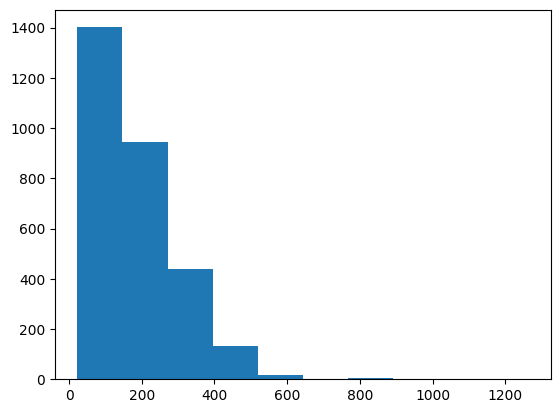

In [ ]:
plt.hist([len(i) for i in df_annotated["lemmatizing_words"]])
plt.show()

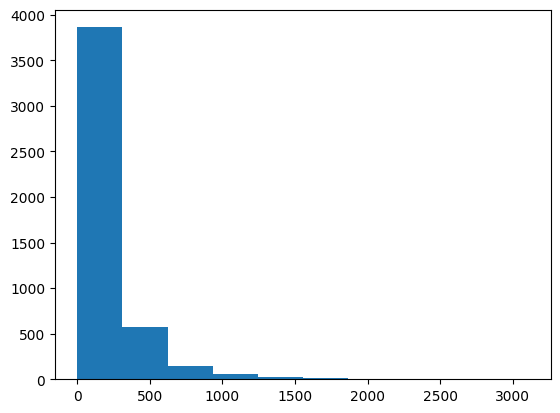

In [ ]:
plt.hist([len(j) for j in df_comments["comment_important_words"]])
plt.show()

## Making  sure that all inputs are about the same size. The length of the comments range from 10 - 8000 characters for the unlabeled and 0- 6000 for the labeled. While the range is big, the majority of the values lied betwen 10 - ~700. Here I'm choosing 500 as a good enough number that will describe the comments well.

In [ ]:
#from keras.preprocessing.sequence import pad_sequences
max_length = 30
X_labeled = tf.keras.utils.pad_sequences(X_labeled,maxlen=max_length,padding='post')

X_unlabeled = tf.keras.utils.pad_sequences(X_unlabeled,maxlen=max_length,padding='post')


In [ ]:
print(f"The length of the indexes of the labeled data  is {len(tokenizer_lab.index_word)} \n and the size of the unlabeled data index is {len(tokenizer.index_word)}")

The length of the indexes of the labeled data  is 6673 
 and the size of the unlabeled data index is 7813


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-05-22 23:37:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-22 23:37:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-22 23:37:36--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
def pre_trained_emb(voc, word_index):

  path_to_glove_file = os.path.join(os.path.expanduser("~"), "/content/glove.6B.100d.txt")
  embeddings_index = {}
  with open(path_to_glove_file) as f:
    for line in f:
      word, coefs = line.split(maxsplit=1)
      coefs = np.fromstring(coefs, "f", sep=" ")
      embeddings_index[word] = coefs

  print("Found %s word vectors." % len(embeddings_index))

  num_tokens = len(voc) + 2
  embedding_dim = 100
  hits = 0
  misses = 0

# Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:

      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1

    else:
      misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))

  embedding_layer = Embedding(num_tokens,embedding_dim,\
                              embeddings_initializer=keras.initializers.Constant(embedding_matrix),trainable=False)
  
  return embedding_layer


In [ ]:
voc = tokenizer_lab.index_word
word_index = dict(zip(voc, range(len(voc))))
emb_layer = pre_trained_emb(voc, word_index)

Found 400000 word vectors.
Converted 0 words (6673 misses)


In [ ]:

vocab_size =  6673 +1
def define_model():
   model = Sequential()
   #the embedding will take all the voca index, the output will be 50 on each and the input is the same as the padded input since the input will be of that size
   #embedding_layer = 
   #model.add(Dense())
   emb = Embedding(input_dim=vocab_size,output_dim=8,input_length=max_length)
   model.add(emb)
   #model.add(emb_layer)
   #the input of the LSTM layer's input equal to the output of the embedding layer
   model.add(LSTM(100))
   model.add(Dropout(.5))
   #not sure if this layer should be the same size as the output of the LSMT layer?
   model.add(Dense(100, activation = 'relu'))
   #adding the ouput layer
   model.add(Dense(5, activation = "softmax"))
   model.summary()
   #model.compile("adam", loss="categorical_crossentropy", metrics=['accuracy'], run_eagerly=True)
   return model


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_labeled,y_labeled,test_size=0.3, random_state=100, shuffle=True)
#print(X_train, y_train, X_train.shape, y_train.shape)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_bal, y_bal = over_sampler.fit_resample(X_train, y_train)
print(X_train, X_bal)

from sklearn.ensemble import RandomForestClassifier
labels = np.array(df_annotated["annotation"].value_counts().index.to_list())
rf = RandomForestClassifier(n_estimators = 500, random_state = 1)
rf.fit(X_bal, y_bal)

y_result= rf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_result))

[[ 112  994  157 ... 3228   24   99]
 [  35   68  307 ...    0    0    0]
 [1900   69    6 ...    0    0    0]
 ...
 [  36   83  199 ...    0    0    0]
 [  43  565  590 ...  451   86  480]
 [  98 1800 2532 ...    0    0    0]] [[ 112  994  157 ... 3228   24   99]
 [  35   68  307 ...    0    0    0]
 [1900   69    6 ...    0    0    0]
 ...
 [ 311   25   38 ...    0    0    0]
 [3540 1349 2249 ...    0    0    0]
 [   1   20 4535 ...    0    0    0]]
              precision    recall  f1-score   support

           0       0.68      0.07      0.13       238
           1       0.68      0.09      0.16       284
           2       0.68      0.07      0.12       197
           3       0.50      0.04      0.08        92
           4       0.38      0.04      0.07        72

   micro avg       0.64      0.07      0.13       883
   macro avg       0.58      0.06      0.11       883
weighted avg       0.64      0.07      0.13       883
 samples avg       0.07      0.07      0.07       883



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(y_bal.shape,  y_train.shape, type(y_bal), type(y_train))

(3445,) (2059, 1) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
print(X_train.shape, X_bal.shape, type(X_train), type(X_bal))

(2059, 30) (3445, 30) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
model = define_model()
model.compile("adam", loss="categorical_crossentropy", metrics=['accuracy'])

over_sampler = RandomOverSampler(random_state=42)
X_bal, y_bal = over_sampler.fit_resample(X_train, y_train)

#hist = model.fit(X_bal, y_bal, validation_data=(X_test, y_test), epochs=100)
#y_pred = model.predict(X_test)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 30, 8)             53392     
                                                                 
 lstm_4 (LSTM)               (None, 100)               43600     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 5)                 505       
                                                                 
Total params: 107,597
Trainable params: 107,597
Non-trainable params: 0
_________________________________________________________________


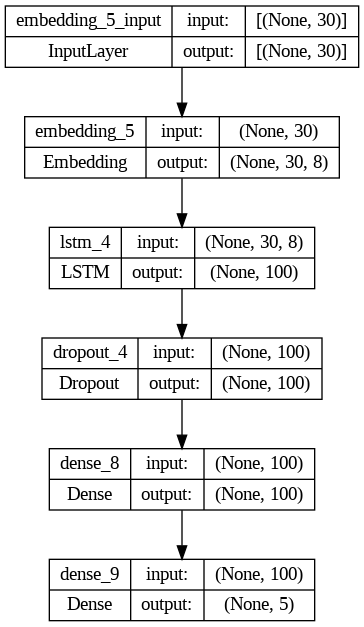

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/den_yelp_notebooks/model_plot.png', show_shapes=True, show_layer_names=True)

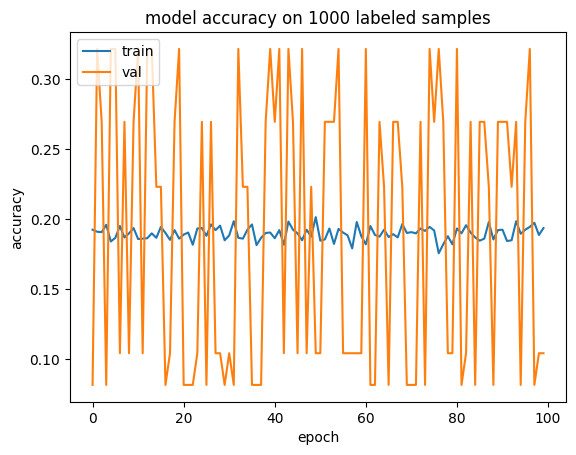

In [ ]:
history = hist.history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy on 1000 labeled samples')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
X_labeled

array([[  69,  481,  108, ...,  234,   57,   69],
       [3888,    4,    2, ...,    0,    0,    0],
       [  76,   18,    4, ...,   93,  825,  107],
       ...,
       [ 881,  147,   19, ...,  240, 2470,  144],
       [   8,   56,    2, ...,    0,    0,    0],
       [   1, 2188,  255, ...,    0,    0,    0]], dtype=int32)

In [ ]:
z = TSNE(n_components=2).fit_transform(X_labeled)
df = pd.DataFrame()
df["y"] = y_labeled_.flatten()
#decode(y_test)
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

<ipython-input-76-c9ccb19cf746>:1: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


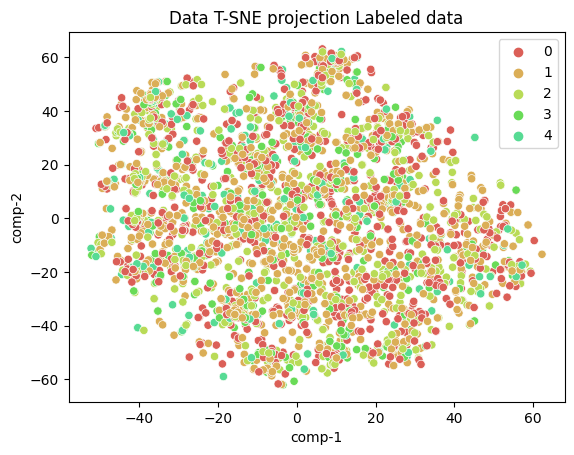

In [ ]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="Data T-SNE projection Labeled data")
plt.savefig("/content/drive/MyDrive/den_yelp_notebooks/tsne_labeled_data.png")

In [ ]:
class PseudoCallback(Callback):

  def __init__(self, model, n_labeled_sample, batch_size, X, Y,X_unlabeled, n_classes):

    self.n_labeled_sample = n_labeled_sample
    self.batch_size = batch_size
    self.model = model
    self.n_classes = n_classes
  
    #Splitting the labeled data into test and train
    X_train, self.X_test, y_train, self.y_test = train_test_split(X,Y,test_size=0.3, random_state=42, shuffle=True)

    #balances the dataset
    over_sampler = RandomOverSampler(random_state=42)
    X_bal, y_bal = over_sampler.fit_resample(X_train, y_train)
  
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    
    #gets the number of labeled data to use for training
    self.X_train_labeled = X_bal[indices[:n_labeled_sample]]
    #X_train[indices[:n_labeled_sample]]
    self.y_train_labeled = y_bal[indices[:n_labeled_sample]]
    self.y_train_labeled = self.y_train_labeled.reshape(self.y_train_labeled.shape[0], 1)
    #y_train[indices[:n_labeled_sample]]
    self.X_train_unlabeled = X_unlabeled[indices[n_labeled_sample -200:]]
    
    self.y_train_unlabeled_prediction = np.random.randint(5, size=(self.X_train_unlabeled.shape[0], 1))
    print(f"shapes to start :{self.y_train_labeled.shape} and unlabe = {self.y_train_unlabeled_prediction.shape}, x unla {self.X_train_unlabeled.shape}")
    
    
    self.train_steps_per_epoch = X_train.shape[0] // batch_size
    self.test_steps_per_epoch = self.X_test.shape[0] // batch_size
    
    self.alpha_t = 0.0

    #self.unlabeled_accuracy = []
    self.labeled_accuracy = []
    self.unlabeled_pred =[]
    self.x_unlab = []

  def train_mixture(self):

    X_train_join = np.r_[self.X_train_labeled, self.X_train_unlabeled]
  
    y_train_join = np.r_[self.y_train_labeled, self.y_train_unlabeled_prediction]

    flag_join = np.r_[np.repeat(0.0, self.X_train_labeled.shape[0]),
                      np.repeat(1.0, self.X_train_unlabeled.shape[0])].reshape(-1,1)

    indices = np.arange(flag_join.shape[0])
    np.random.shuffle(indices)
    return X_train_join[indices], y_train_join[indices], flag_join[indices]

  def train_generator(self):
    while True:
      X, y, flag = self.train_mixture()
      n_batch = X.shape[0] // self.batch_size
      for i in range(n_batch):
        X_batch = (X[i*self.batch_size:(i+1)*self.batch_size]).astype(np.float32)
        y_batch = to_categorical(y[i*self.batch_size:(i+1)*self.batch_size], self.n_classes)
        y_batch = np.c_[y_batch, flag[i*self.batch_size:(i+1)*self.batch_size]]
      
        yield X_batch, y_batch

  def test_generator(self):
    while True:
      indices = np.arange(self.y_test.shape[0])
      np.random.shuffle(indices)
      for i in range(len(indices)//self.batch_size):
        current_indices = indices[i*self.batch_size:(i+1)*self.batch_size]
        X_batch = (self.X_test[current_indices]).astype((np.float32))
        
        y_batch = to_categorical(self.y_test[current_indices], self.n_classes)
        y_batch = np.c_[y_batch, np.repeat(0.0, y_batch.shape[0])]
        yield X_batch, y_batch

  def loss_function(self, y_true, y_pred):

    
    y_true_item = y_true[:, :-1]
    #print(f"shape predi {y_pred.shape}, and vals {y_pred}")
    #y_true[:, :-1]
    unlabeled_flag = y_true[:, -1:]
    
    entropies = categorical_crossentropy(y_true_item, y_pred)
    coefs = 1.0-unlabeled_flag + self.alpha_t * unlabeled_flag # 1 if labeled, else alpha_t
    return coefs * entropies

  def accuracy(self, y_true, y_pred):

    #print(f"is this the problem? This is the shape of y true {y_true.shape}")
    y_true_item = y_true[:, :-1]
    return categorical_accuracy(y_true_item, y_pred)

  def on_epoch_end(self, epoch, logs):

    #defining alpha
    if epoch < 10:
        self.alpha_t = 0.0
    elif epoch >= 70:
        self.alpha_t = 3.0
    else:
        self.alpha_t = (epoch - 10.0) / (70.0-10.0) * 3.0
  
    #returns indexes of the values 
    #print(self.X_train_labeled, np.unique(self.X_train_labeled))
    y_train_labeled_prediction = np.argmax(self.model.predict(self.X_train_labeled), axis = -1).reshape(-1, 1)

    #print(y_train_labeled_prediction, self.y_train_labeled)

    self.y_train_unlabeled_prediction = np.argmax(self.model.predict(self.X_train_unlabeled), axis=-1).reshape(-1, 1)
    self.unlabeled_pred.append(self.y_train_unlabeled_prediction )
    self.x_unlab.append(self.X_train_unlabeled)
    self.labeled_accuracy.append(np.mean(self.y_train_labeled == y_train_labeled_prediction))

    print(f"labeled accuracy {self.labeled_accuracy[-1]}") #, unlabeled accuracy : {self.unlabeled_accuracy[-1]}")

      
  def decode(self, array):
    decoded = []
    for y in array:
      for j in range(len(y)):
        if y[j]== 1:
          decoded.append(j)
    return np.array(decoded)

  def on_train_end(self, logs):
    
    y_true = np.ravel(self.y_test)
      
    #getting the input and the weights of the last trained layer
    emb_model = Model(self.model.input, self.model.layers[-2].output)
    plot_model(emb_model, to_file='/content/drive/MyDrive/den_yelp_notebooks/model_plot_new.png', show_shapes=True, show_layer_names=True)
    embedding = emb_model.predict(self.X_test)
    #Pickling
    with open("unlabeled.csv", "wb") as fp: pickle.dump( self.unlabeled_pred, fp)

    proj = TSNE(n_components=2).fit_transform(embedding)
    cmp = plt.get_cmap("tab10")
    plt.figure()

    for i in range(self.n_classes):
        select_flag = y_true == i
        plt_latent = proj[select_flag, :]
        plt.scatter(plt_latent[:,0], plt_latent[:,1], color=cmp(i), marker=".")

    plt.savefig(f"result_pseudo_trans_mobile/embedding_{self.n_labeled_sample:05}.png")
        

In [ ]:
y_labeled_.shape

(2942, 1)

800 Starts
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 8)             53392     
                                                                 
 lstm (LSTM)                 (None, 100)               43600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 107,597
Trainable params: 107,597
Non-trainable params: 0
_________________________________________________________________
shapes to start :(800, 1) and unlabe = 

<ipython-input-15-7c18e5acac1c>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(pseudo.train_generator(), steps_per_epoch=pseudo.train_steps_per_epoch,


46/46 [==============================] - 1s 10ms/step
labeled accuracy 0.355
8/8 [==============================] - 8s 487ms/step - loss: 0.5703 - accuracy: 0.2150 - val_loss: 1.5849 - val_accuracy: 0.3360
Epoch 2/100
46/46 [==============================] - 0s 10ms/step
labeled accuracy 0.33625
8/8 [==============================] - 2s 284ms/step - loss: 0.5361 - accuracy: 0.5210 - val_loss: 1.5167 - val_accuracy: 0.3107
Epoch 3/100
46/46 [==============================] - 0s 10ms/step
labeled accuracy 0.33625
8/8 [==============================] - 2s 281ms/step - loss: 0.3896 - accuracy: 0.7190 - val_loss: 2.0375 - val_accuracy: 0.3333
Epoch 4/100
46/46 [==============================] - 1s 11ms/step
labeled accuracy 0.33625
8/8 [==============================] - 2s 285ms/step - loss: 0.2993 - accuracy: 0.7780 - val_loss: 1.7071 - val_accuracy: 0.3227
Epoch 5/100
46/46 [==============================] - 1s 12ms/step
labeled accuracy 0.33625
8/8 [==============================] - 3s 4

<ipython-input-15-7c18e5acac1c>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(pseudo.train_generator(), steps_per_epoch=pseudo.train_steps_per_epoch,


24/24 [==============================] - 0s 10ms/step
labeled accuracy 0.3426666666666667
8/8 [==============================] - 6s 417ms/step - loss: 1.0688 - accuracy: 0.2770 - val_loss: 1.5812 - val_accuracy: 0.3147
Epoch 2/100
24/24 [==============================] - 0s 13ms/step
labeled accuracy 0.3426666666666667
8/8 [==============================] - 3s 383ms/step - loss: 0.9794 - accuracy: 0.5265 - val_loss: 1.6265 - val_accuracy: 0.3240
Epoch 3/100
24/24 [==============================] - 0s 11ms/step
labeled accuracy 0.3426666666666667
8/8 [==============================] - 3s 348ms/step - loss: 0.8463 - accuracy: 0.5680 - val_loss: 1.5190 - val_accuracy: 0.3173
Epoch 4/100
24/24 [==============================] - 0s 10ms/step
labeled accuracy 0.3426666666666667
8/8 [==============================] - 2s 275ms/step - loss: 0.8384 - accuracy: 0.5710 - val_loss: 1.6527 - val_accuracy: 0.3280
Epoch 5/100
24/24 [==============================] - 0s 10ms/step
labeled accuracy 0.342

<ipython-input-15-7c18e5acac1c>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(pseudo.train_generator(), steps_per_epoch=pseudo.train_steps_per_epoch,


9/9 [==============================] - 0s 9ms/step
labeled accuracy 0.336
8/8 [==============================] - 6s 398ms/step - loss: 1.4148 - accuracy: 0.3005 - val_loss: 1.5653 - val_accuracy: 0.3160
Epoch 2/100
9/9 [==============================] - 0s 11ms/step
labeled accuracy 0.336
8/8 [==============================] - 3s 352ms/step - loss: 1.3220 - accuracy: 0.3960 - val_loss: 1.5912 - val_accuracy: 0.3000
Epoch 3/100
9/9 [==============================] - 0s 10ms/step
labeled accuracy 0.336
8/8 [==============================] - 3s 365ms/step - loss: 1.2921 - accuracy: 0.4125 - val_loss: 1.4960 - val_accuracy: 0.3187
Epoch 4/100
9/9 [==============================] - 0s 10ms/step
labeled accuracy 0.336
8/8 [==============================] - 3s 348ms/step - loss: 1.2557 - accuracy: 0.4180 - val_loss: 1.5200 - val_accuracy: 0.3213
Epoch 5/100
9/9 [==============================] - 0s 9ms/step
labeled accuracy 0.336
8/8 [==============================] - 3s 477ms/step - loss: 1.

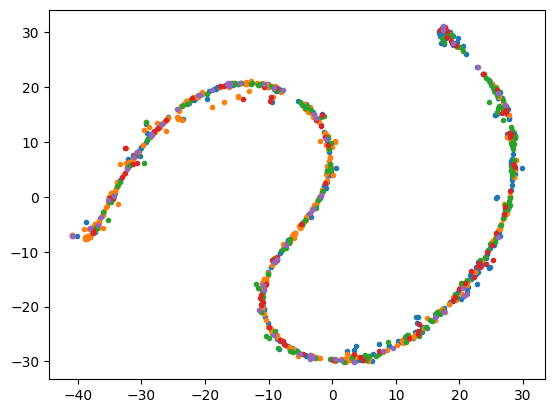

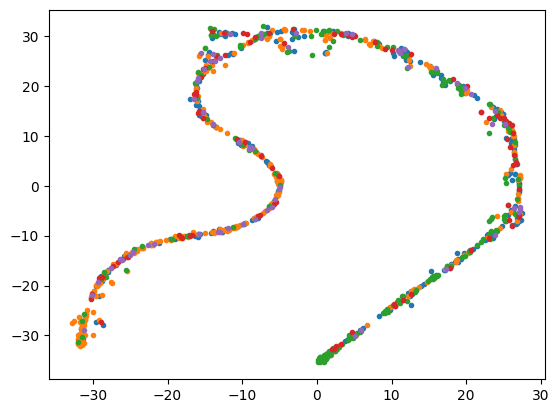

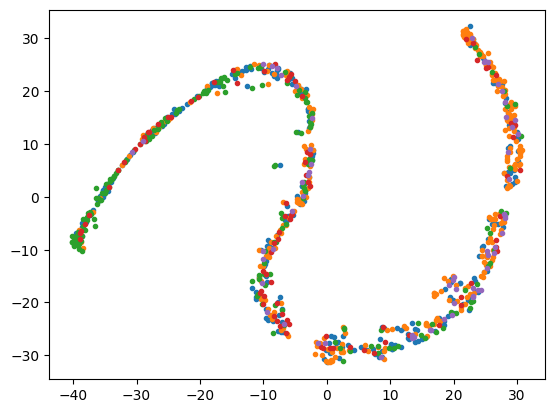

In [ ]:
hist_models = []
predictions = []
x_labels_used = []
def train(n_labeled_data):
  
    model =define_model()
    #model, n_labeled_sample, batch_size, X, Y, X_unlabeled, n_classes, padding_len = 1000
    #there are five total classes: Care, Authority, Equality, Loyalty, and Purity 
    #def __init__(self, model, n_labeled_sample, batch_size, X, Y,X_unlabeled, n_classes):
  
    pseudo = PseudoCallback(model, n_labeled_data, 250, X_labeled, y_labeled_, X_unlabeled, 5)
    model.compile("adam", loss=pseudo.loss_function, metrics=[pseudo.accuracy])

    if not os.path.exists("result_pseudo_trans_mobile"):
        os.mkdir("result_pseudo_trans_mobile")

    hist = model.fit_generator(pseudo.train_generator(), steps_per_epoch=pseudo.train_steps_per_epoch,
                               validation_data=pseudo.test_generator(), callbacks=[pseudo],
                               validation_steps=pseudo.test_steps_per_epoch, epochs=100).history

    pred = pseudo.unlabeled_pred
    x_unlab = pseudo.x_unlab
    x_labels_used.append(x_unlab)
    predictions.append(pred)

    hist["labeled_accuracy"] = pseudo.labeled_accuracy
    #hist["unlabeled_accuracy"] = pseudo.unlabeled_accuracy
    hist_models.append(hist)


    with open(f"result_pseudo_trans_mobile/history_{n_labeled_data:05}.dat", "wb") as fp:
        pickle.dump(hist, fp)

if __name__ == "__main__":
    #n_batches = [500, 1000, 5000, 10000]
    #n_batches = [500, 800]
    n_batches = [800, 1500,2000]
    for nb in n_batches:
        print(nb, "Starts")
        train(nb)

    with zipfile.ZipFile("result_pseudo_trans_mobile_2.zip", "w") as zip:
        for f in glob.glob("result_pseudo_trans_mobile/*"):
            zip.write(f)


In [ ]:
def alpha(epochs):
  alp_array = []
  for epoch in epochs:
    if epoch < 10:

      alpha_t = 0.0
      alp_array.append(alpha_t)

    elif epoch >= 70:
      alpha_t = 3.0
      alp_array.append(alpha_t)
    else:
      alpha_t = (epoch - 10.0) / (70.0-10.0) * 3.0
      alp_array.append(alpha_t)
  return np.array(alp_array)

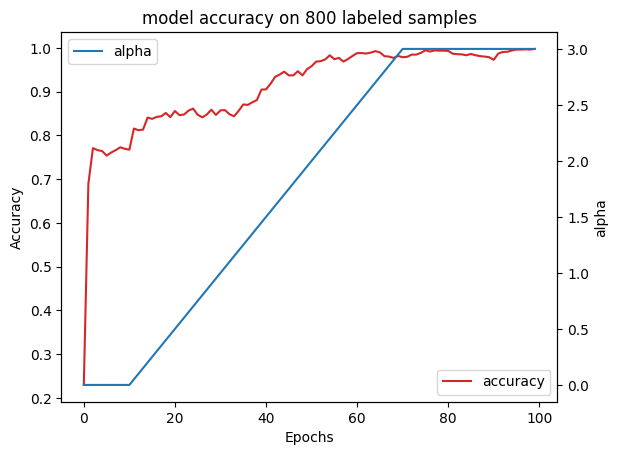

In [ ]:
history = hist_models[0]
fig, ax1 = plt.subplots()
ax1.plot(history['accuracy'], color="tab:red", label ="accuracy")
plt.xlabel("Epochs")
ax1.legend(loc = 'lower right') #loc='upper righ')
plt.ylabel("Accuracy")
ax2 = ax1.twinx()

ax2.plot(alpha(np.arange(100)), label="alpha")
plt.title('model accuracy on 800 labeled samples')
ax2.legend(loc = 'best')
#ax2.x_label("Alpha value (epoch dependent)")
plt.savefig("/content/drive/MyDrive/den_yelp_notebooks/800.png")
plt.ylabel("alpha")
plt.show()


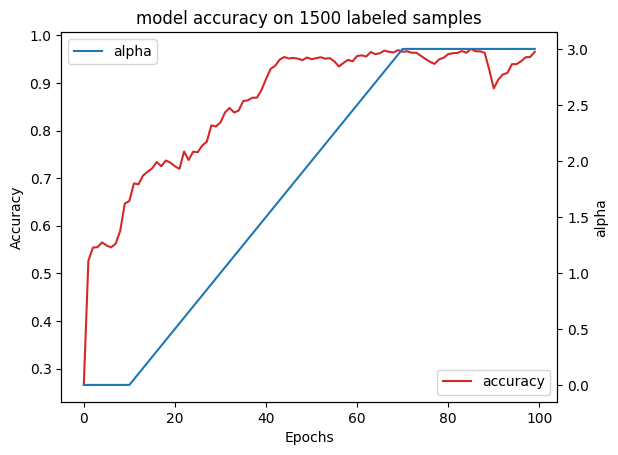

In [ ]:
history = hist_models[1]
fig, ax1 = plt.subplots()
ax1.plot(history['accuracy'], color="tab:red", label ="accuracy")
plt.xlabel("Epochs")
ax1.legend(loc = 'lower right')
plt.ylabel("Accuracy")
ax2 = ax1.twinx() 
ax2.plot(alpha(np.arange(100)), label="alpha")
ax2.legend(loc = 'best')
plt.title('model accuracy on 1500 labeled samples')
plt.legend()
plt.savefig("/content/drive/MyDrive/den_yelp_notebooks/1500.png")
plt.ylabel("alpha")
plt.show()

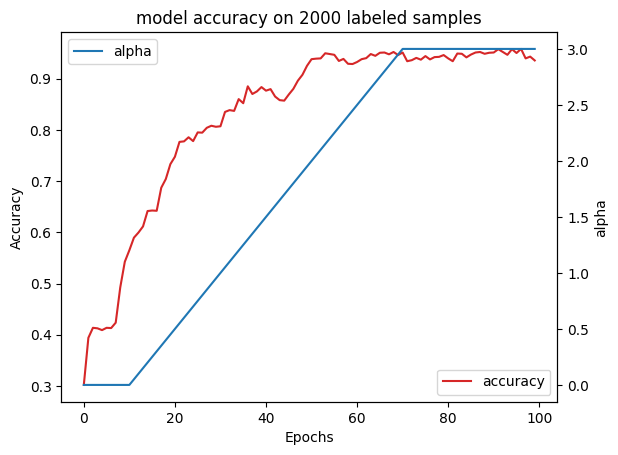

In [ ]:
history = hist_models[2]
fig, ax1 = plt.subplots()
ax1.plot(history['accuracy'], color="tab:red", label ="accuracy")
plt.xlabel("Epochs")
ax1.legend(loc = 'lower right')
plt.ylabel("Accuracy")
ax2 = ax1.twinx() 
ax2.plot(alpha(np.arange(100)), label="alpha")
ax2.legend(loc = 'best')
plt.title('model accuracy on 2000 labeled samples')
plt.legend()
plt.savefig("/content/drive/MyDrive/den_yelp_notebooks/2000.png")
plt.ylabel("alpha")
plt.show()

In [ ]:
x_labels_used_ = np.ravel(np.array(x_labels_used, dtype=object))
predictions_ = np.ravel(np.array(predictions, dtype=object))

In [ ]:
len(x_labels_used_[299])

259

In [ ]:
predictions_[1][1]

In [ ]:
predictions_[0][0]

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

<ipython-input-26-9e2445b7ae86>:8: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


[Text(0.5, 1.0, 'MNIST data T-SNE projection Labeled data')]

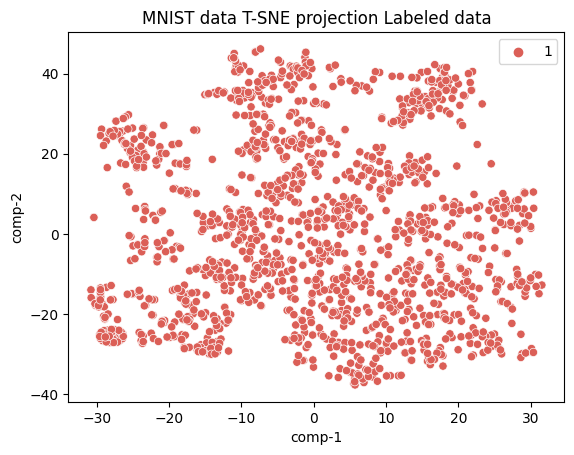

In [ ]:
z = TSNE(n_components=2).fit_transform(x_labels_used_[1])
df = pd.DataFrame()

#decode(y_test)
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
df["y"] = predictions_[1]
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="MNIST data T-SNE projection Labeled data")
#plt.savefig("/content/drive/MyDrive/den_yelp_notebooks/tsne_labeled_data.png")

<ipython-input-32-a33950a7ba1d>:8: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


[Text(0.5, 1.0, 'MNIST data T-SNE projection Labeled data')]

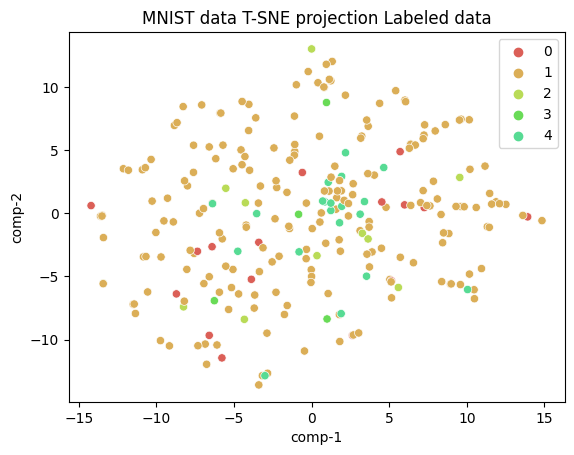

In [ ]:
z = TSNE(n_components=2).fit_transform(x_labels_used_[299])
df = pd.DataFrame()

#decode(y_test)
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
df["y"] = predictions_[299]
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="MNIST data T-SNE projection Labeled data")

<ipython-input-133-c7b79e9e8398>:8: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


[Text(0.5, 1.0, 'T-SNE projection ulabeled data Predictions with 800 labeled samples')]

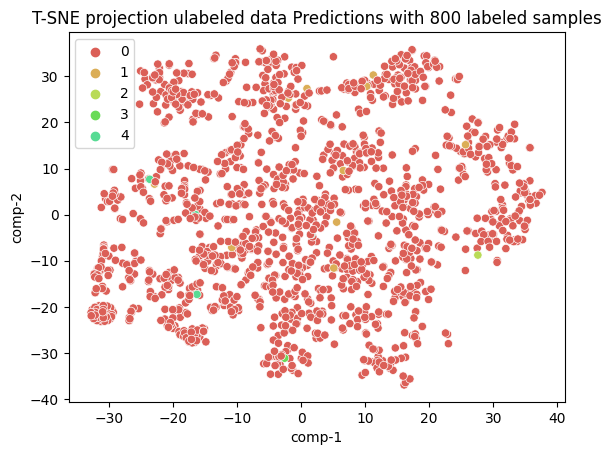

In [ ]:
z = TSNE(n_components=2).fit_transform(x_labels_used_[0][99])
df = pd.DataFrame()

#decode(y_test)
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
df["y"] = predictions_[0][99]
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="T-SNE projection ulabeled data Predictions with 800 labeled samples")

<ipython-input-134-bdedf9d4187f>:8: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


[Text(0.5, 1.0, 'T-SNE projection ulabeled data Predictions with  1500 labeled samples')]

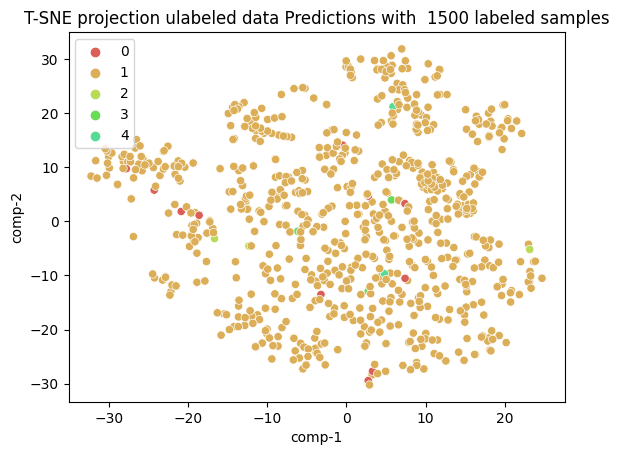

In [ ]:
z = TSNE(n_components=2).fit_transform(x_labels_used_[1][99])
df = pd.DataFrame()

#decode(y_test)
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
df["y"] = predictions_[1][99]
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="T-SNE projection ulabeled data Predictions with  1500 labeled samples")

<ipython-input-155-c9546e07bd4d>:8: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


[Text(0.5, 1.0, 'T-SNE projection ulabeled data Predictions with 2000 labeled samples')]

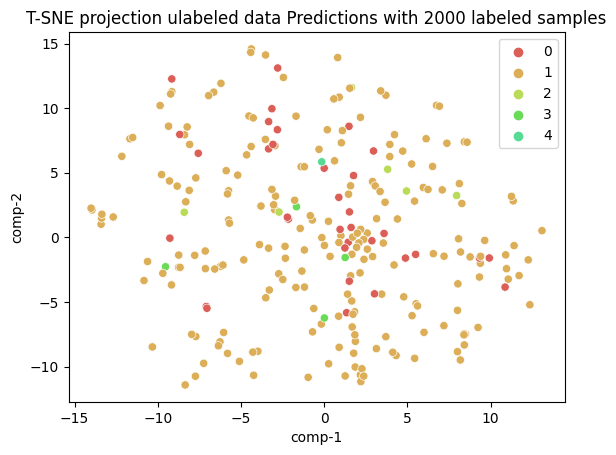

In [ ]:
z = TSNE(n_components=2).fit_transform(x_labels_used_[2][90])
df = pd.DataFrame()

#decode(y_test)
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
df["y"] = predictions_[2][90]
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="T-SNE projection ulabeled data Predictions with 2000 labeled samples")

In [ ]:
i = 290
plt.figure(figsize = (8, 8))
plt.title("t-SNE plot with pseudo labels assigned to unlabeled data")
for x in x_labels_used_[290:]:
  #print(x)
  z = TSNE(n_components=2).fit_transform(x)
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]
  df["y"] = predictions_[i]
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="T-SNE projection unlabeled data Predictions with 2000 labeled samples")
  i+=1

plt.show()

In [ ]:
x_labels_used_ = np.ravel(np.array(x_labels_used, dtype=object))
predictions_ = np.ravel(np.array(predictions, dtype=object))



1.   [1. 0. 0. 0. 0.] ['Authority'] [0]
2.   [0. 1. 0. 0. 0.] ['Care']      [1]
3.   [0. 0. 1. 0. 0.] ['Equality']  [2]
4.   [0. 0. 0. 1. 0.] ['Loyalty']   [3]
5.   [0. 0. 0. 0. 1.] ['Purity']    [4]






In [ ]:
care/harm,
fairness/cheating,
loyalty/betrayal,
authority/subversion,
sanctity/degradation,
libery/oppression.

In [ ]:
values = {0:"Authority/subversion", 1:"Care/harm", 2:"Equality/inequality", 3:"Loyalty/betrayal", 4: "Purity/degradation"}
values[0]

'Authority/subversion'

In [ ]:
text_0 = tokenizer.sequences_to_texts(x_labels_used_[0])
lab_0 = predictions_[0]

In [ ]:
#looking at first 10 comments and labels
for i in range(10):
  print(f" text: [{text[i]}] with labeled: {values[lab_0[i][0]]}")

 text: ['say' 'enough' 'need'] with labeled: Care/harm
 text: ['give' 'fuck' 'chang' 'want' 'tip' 'wtf'] with labeled: Care/harm
 text: ['immedi' 'chosen' 'candid' 'space' 'forc'] with labeled: Care/harm
 text: ['100'] with labeled: Care/harm
 text: ['therapi' 'indoctrin'] with labeled: Care/harm
 text: ['bill' 'fold' 'origami' 'someth' 'need' 'go' 'back' 'clear' 'could' 'ride' 'consciou' 'bud' 'better' 'check' 'make' 'sure'] with labeled: Care/harm
 text: ['lol' 'two' 'year' 'yoga' 'seminar' 'self' 'care' 'need' 'call' 'themself' 'therapist'] with labeled: Care/harm
 text: ['dead' 'rot'] with labeled: Care/harm
 text: ['think' 'make' 'excel' 'comparison' 'undisplay' 'art' 'take' 'next' 'step' 'imagin' 'digit' 'money' 'use' 'gold' 'coin' 'paper' 'mostli' 'digit'] with labeled: Care/harm
 text: ['counselor' 'hard' 'come' 'fact' 'town' 'two' 'three' 'univers' 'offer' 'counsel' 'program' 'christian' 'unaccredit' 'prevent' 'graduat' 'obtain' 'state' 'licens' 'field' 'need' 'regul' 'higher'

In [ ]:
text_0 = tokenizer.sequences_to_texts(x_labels_used_[299])
lab_0 = predictions_[299]
print(len(text_0), len(lab_0))

259 259


In [ ]:
for i in range(10):
  print(f" text: [{text[i]}] with labeled: {values[lab_0[i][0]]}")

 text: ['say' 'enough' 'need'] with labeled: Care/harm
 text: ['give' 'fuck' 'chang' 'want' 'tip' 'wtf'] with labeled: Care/harm
 text: ['immedi' 'chosen' 'candid' 'space' 'forc'] with labeled: Care/harm
 text: ['100'] with labeled: Care/harm
 text: ['therapi' 'indoctrin'] with labeled: Care/harm
 text: ['bill' 'fold' 'origami' 'someth' 'need' 'go' 'back' 'clear' 'could' 'ride' 'consciou' 'bud' 'better' 'check' 'make' 'sure'] with labeled: Care/harm
 text: ['lol' 'two' 'year' 'yoga' 'seminar' 'self' 'care' 'need' 'call' 'themself' 'therapist'] with labeled: Purity/degradation
 text: ['dead' 'rot'] with labeled: Care/harm
 text: ['think' 'make' 'excel' 'comparison' 'undisplay' 'art' 'take' 'next' 'step' 'imagin' 'digit' 'money' 'use' 'gold' 'coin' 'paper' 'mostli' 'digit'] with labeled: Purity/degradation
 text: ['counselor' 'hard' 'come' 'fact' 'town' 'two' 'three' 'univers' 'offer' 'counsel' 'program' 'christian' 'unaccredit' 'prevent' 'graduat' 'obtain' 'state' 'licens' 'field' 'need

In [ ]:
n = 156
text_0 = tokenizer.sequences_to_texts(x_labels_used_[n])
lab_0 = predictions_[n]
print(len(text_0), len(lab_0))
for i in range(10):
  print(f"TEXT: [{text_0[i]}], LABEL: {values[lab_0[i][0]]}")

759 759
TEXT: ['immedi' 'doubl' 'check' 'wrong' 'walk' 'away' 'smh'], LABEL: Care/harm
TEXT: ['honestli' 'look' 'post' 'histori' 'cring' 'shit' 'person'], LABEL: Care/harm
TEXT: ['care' 'look' 'real' 'answer' 'op' 'crypto' 'hate' 'train' 'caus' 'fuck' 'ton' 'ignor' 'upvot' 'quit' 'solid' 'answer' 'downvot' 'reddit' 'day' 'place' 'ask' 'question' 'crypto' 'get' 'truth' 'fact'], LABEL: Care/harm
TEXT: ['sound' 'like' 'ask' 'therapist' 'stop' 'religi' 'stuff' 'also' 'mess' 'may' 'also' 'breach' 'ethic' 'depend' 'guidelin' 'regul' 'therapist' 'licensur' 'might' 'worth' 'look' 'state' 'guidelin' 'assum' 'us' 'file' 'complaint' 'state' 'licens' 'board'], LABEL: Care/harm
TEXT: ['could' 'mindset' 'ever' 'requir' 'situat' 'like' 'happen' 'one' 'posit' 'mind' 'set' 'sure' 'one' 'duck' 'die' 'space'], LABEL: Care/harm
TEXT: ['give' 'money' 'back' 'believ' 'even' 'unsur'], LABEL: Care/harm
TEXT: ['simpl' 'answer' 'complex' 'question' 'ask' 'right' 'probabl'], LABEL: Care/harm
TEXT: ['absolut'], L